# Optimization with CVXPy


In [1]:
%pylab inline
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
from utils import img_utils

Populating the interactive namespace from numpy and matplotlib


In [3]:
reload(img_utils)

<module 'utils.img_utils' from 'utils/img_utils.py'>

## Load DMRI image

/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /user/lgomez/home/.dipy/stanford_hardi 


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

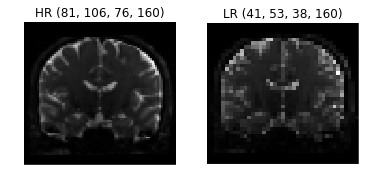

In [2]:
from utils.DataGetter import DataGetter
from utils.DownsampledImage import DownsampledImage

d = DataGetter()
datas_names = [
    DataGetter.STANDFORD_HARDI_DATA, #(81, 106, 76, 160)
    #DataGetter.TAIWAN_NTU_DSI_DATA,  #(96, 96, 60, 203)
    #DataGetter.SHERBROOKE_3SHELL_DATA #(128, 128, 60, 193)
]

scale=2
datas = d.get_data(datas_names)
name = datas_names[0]
lr_hr_img = DownsampledImage(name, datas[name]['img'], datas[name]['gtab'], scale)

img_hr = lr_hr_img.get_hr_img()
img_lr = lr_hr_img.get_lr_img()
img_utils._isc(img_hr,img_lr, titles=['HR '+str(img_hr.shape), 'LR '+str(img_lr.shape)] )

### Select Area of Interest

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

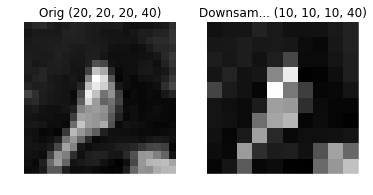

In [3]:
img_shape = img_lr.shape
volume_range = (20, 40, 30, 50, 30, 50)
bval_range = (0,40)

i_lr = img_lr[10:20, 15:25, 15:25,:40]
i_hr = img_hr[20:40, 30:50, 30:50,:40]
img_utils._isc(i_hr,i_lr, titles=['Orig '+str(i_hr.shape), 'Downsam... '+str(i_lr.shape)] )

## Problem definition

$ \min_{Y_{hr}} \{ ||GY_{lr} - Y_{hr}||^2 \}$ st $Y_{hr} \geq 0$

In [30]:
Nx, Ny, Nz, bval = i_hr.shape
vhr = Nx*Ny*Nz
vlr = vhr/8

Yhr = cvx.Variable(vhr, bval)
Ylr = i_lr.reshape((vlr, bval))
G = cvx.Parameter(*G_rala.shape, value=G_rala)

# Form objective.
obj = cvx.Minimize(cvx.sum_squares(G*Yhr- Ylr))

# Create two constraints.
constraints = [Yhr >= 0]

# Form and solve problem.
prob = cvx.Problem(obj, constraints)
prob

Problem(Minimize(Expression(CONVEX, POSITIVE, (1, 1))), [LeqConstraint(Constant(CONSTANT, ZERO, (1, 1)), Variable(8000, 160))])

In [38]:
prob.solve()  # Returns the optimal value.
print "status:", prob.status
print "optimal value", prob.value
#print "optimal var", Yhr.value

status: optimal_inaccurate
optimal value -0.0204163155234


shape= (20, 20, 20, 160)


<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

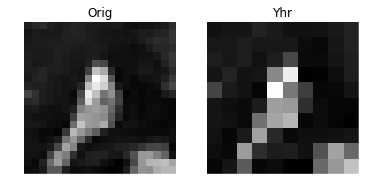

In [39]:
A = np.asarray(Yhr.value).reshape(i_hr.shape)
print 'shape=',A.shape
img_utils._isc(i_hr,A,titles=['Orig', 'Yhr'] )

# Predicting the G downsampling Matrix

In [50]:
reload(rr)
reload(sc)
reload(db)
reload(ixs)

<module 'utils.DmriVolumesRandomIndexers' from 'utils/DmriVolumesRandomIndexers.pyc'>

In [51]:
import utils.RandomRanges as rr
import utils.DmriVolumesRandomIndexers as ixs
import utils.DmriSampleCreators as sc
import utils.ml.MLDataBuilder as db


# Estrategia de volumne y rango de bvals (fija)
volume_strategy, bval_strategy = rr.Fixed3DRange(*volume_range), rr.Fixed1DRange(*bval_range)
# El que combina ambas
dmri_volume_indexer = ixs.DmriVolumeRandomIndexer(volume_strategy, bval_strategy)
# Equivalencia entre indices de la hr y lr 
fconvert = lambda *lr_tuple : tuple(np.array(lr_tuple[:-2])*2)+lr_tuple[-2:]
# Iterador de dmri imagen lr y hr
lr_hr_vol_it = ixs.DmriLrHrCubicPatchVolumeRandomIndexer(dmri_volume_indexer, fconvert, from_lr2hr=True)

# El que toma la imagen original y downsampleada y les pone ruido
sample_creator = sc.NoisedLrHrDmriSampleCreator(lr_hr_img, lr_hr_vol_it, snr=20, noise_type='rician')


In [52]:
n_samples = 100

# Builder that organize data like the ML wants 
sdb = db.SimpleMlDataBuilder(sample_creator, n_samples)

X, Y = sdb.build()
print X.shape, Y.shape

Samples for  standfor_hardi : 100 of inf
<class 'utils.dmri_patch_operations.DmriPatch.NoisedDmriPatchRef'> <utils.dmri_patch_operations.DmriPatch.NoisedDmriPatchRef object at 0x7f42f9928990>


AttributeError: 'NoisedDmriPatchRef' object has no attribute 'self'

In [24]:
lala  = lambda *argv : argv
lala(*volume_range)

(20, 40, 30, 50, 30, 50)